In [1]:
import pandas as pd
import numpy as np

In [29]:
tags = pd.read_csv('Tag_Prediction_Data/Tags.csv')
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [30]:
temp = tags['Tag'].value_counts()
temp = pd.DataFrame(temp)
temp = temp.reset_index()
temp.head()

,index,Tag
0,javascript,124155
1,java,115212
2,c#,101186
3,php,98808
4,android,90659


In [31]:
temp.rename(columns = {'index':'Tag' , 'Tag':'Counts'}, inplace = True)
temp.head()

,Tag,Counts
0,javascript,124155
1,java,115212
2,c#,101186
3,php,98808
4,android,90659


In [32]:
tags = pd.merge(tags , temp , on = 'Tag')
tags.head()

,Id,Tag,Counts
0,80,flex,2430
1,10870,flex,2430
2,14350,flex,2430
3,20510,flex,2430
4,20910,flex,2430


### Choosing the 20 immediate tags which have count >= 4021 - for a decent data size and less imbalance in classes i.e., tags

In [33]:
temp.loc[temp["Counts"] >= 4021, :].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             97,  98,  99, 100, 101, 102, 103, 104, 105, 106],
           dtype='int64', length=107)

In [34]:
# stores the row indices of the chosen tags (i.e., tags with counts >= 4021) from the table - temp
chosen_tags_indices = list(range(106, -1, -1))[:20]
chosen_tags_names = list(temp.loc[chosen_tags_indices, "Tag"].values)

In [35]:
#tags.where(tags['Counts']>=20345 , inplace = True)
tags = tags.loc[tags["Tag"].isin(chosen_tags_names), :]

In [36]:
tags.head()

,Id,Tag,Counts
2430,80,actionscript-3,4039
2431,10870,actionscript-3,4039
2432,14350,actionscript-3,4039
2433,33590,actionscript-3,4039
2434,63390,actionscript-3,4039


In [37]:
tags = tags.sort_values(by = 'Id')
tags.head()

,Id,Tag,Counts
2430,80,actionscript-3,4039
263927,330,class,4485
325131,930,loops,4121
343735,1760,unit-testing,4437
343736,3150,unit-testing,4437


In [38]:
tags['Id'] = tags['Id'].astype('int32')

In [39]:
tags.shape

(86225, 3)

### Tags file ready, importing the questions file - 

In [42]:
q = pd.read_csv('Tag_Prediction_Data/Questions.csv' , encoding='latin-1')

In [43]:
q.shape

(1264216, 7)

In [44]:
q.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [45]:
df = q.drop(['OwnerUserId' ,  'CreationDate' , 'ClosedDate' , 'Score'] , axis =1)

In [46]:
def comb_tags_func(x):
    list_tags = x.values
    tag_comb = ' '.join(list_tags)
    return tag_comb

In [47]:
mapping_dict = tags.groupby('Id')['Tag'].apply(comb_tags_func)

In [48]:
df['tag'] = df['Id'].map(mapping_dict)

In [49]:
df.dropna(inplace=True)
df.shape

(84884, 4)

In [50]:
df['tag'] = df['tag'].apply(lambda x : x.split())
df.head()

,Id,Title,Body,tag
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,[actionscript-3]
5,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[class]
10,930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,[loops]
20,1760,.NET Unit Testing packages?,<p>Getting back into a bit more .NET after a f...,[unit-testing]
36,3150,How to set up unit testing for Visual Studio C++,<p>I'm having trouble figuring out how to get ...,[unit-testing]


### Dataset ready, now Topic Modelling starts - 

In [54]:
from tqdm.notebook import tqdm

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet

In [55]:
tqdm.pandas()

In [52]:
df =df.drop(['Title', 'tag'] , axis =1)
df.head()

,Id,Body
0,80,<p>I've written a database generation script i...
5,330,<p>I am working on a collection of classes use...
10,930,<p>What's the simplest way to connect and quer...
20,1760,<p>Getting back into a bit more .NET after a f...
36,3150,<p>I'm having trouble figuring out how to get ...


In [53]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to C:\Users\Anmol
[nltk_data]     Bhatia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Anmol
[nltk_data]     Bhatia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Anmol
[nltk_data]     Bhatia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anmol Bhatia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Anmol
[nltk_data]     Bhatia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [56]:
df['Body']=df['Body'].str.replace('<p>',' ')

In [57]:
import re
df['Body']=df['Body'].apply(lambda x : re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)' , ' ' , x))

In [58]:
df['Body']=df['Body'].str.replace('</p>',' ')
df['Body']=df['Body'].str.replace('\n',' ')
df['Body']=df['Body'].str.replace('</a>',' ')
df['Body']=df['Body'].str.replace('<a href=" ">','')
df['Body']=df['Body'].apply(lambda x : x.lower())

In [59]:
def ret_pos_tag(txt):
    # tokenizes , removes stop words and other redundant words and returns Parts of Speech(POS) tag for all the remaining words 
    wordsList = nltk.word_tokenize(txt)
    wordsList = [w for w in wordsList if not w in stop_words and len(w) > 3]
    tagged = nltk.pos_tag(wordsList)
    return tagged

stemmer = SnowballStemmer('english')

In [60]:
def lemmatize_stemming(token, tag):
    return stemmer.stem(WordNetLemmatizer().lemmatize(token, pos = tag))

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # default tag is verb
        return wordnet.VERB

def preprocess_text(text):
    result = []
    for token, pos_tag in ret_pos_tag(text):
        result.append(lemmatize_stemming(token, get_wordnet_pos(pos_tag)))
    return result

In [61]:
processed_docs = df['Body'].progress_apply(preprocess_text)
processed_docs[:15]

  0%|          | 0/84884 [00:00<?, ?it/s]

0      [write, databas, generat, script, want, execut...
5      [work, collect, class, use, video, playback, r...
10              [simpl, connect, queri, databas, record]
20     [get, back, .net, few-year, use, full-tim, won...
36     [troubl, figur, test, framework, usabl, visual...
57     [organ, form, allow, user, updat, email, addre...
60     [situat, want, hour, date, date, wrap, around,...
68     [.net, system, build, need, autom, e-mail, not...
77     [compani, current, work, use, selenium, unitin...
82     [even, though, alway, strive, complet, valid, ...
101    [play, around, asp.net, framework, thing, real...
109    [call, code, dragm, /code, unaccept, drag, vie...
113    [difficult, open-end, question, know, think, t...
114    [guess, need, someth, like, code, convert, cha...
126    [determin, router/gateway, java, easili, enoug...
Name: Body, dtype: object

### Feature extraction through bag of words -

In [62]:
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

### Feature extraction through tf-idf -

In [63]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### Running LDAMultiCore using BoWs -

In [64]:
lda_bow = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dictionary, passes = 2, workers = 2)
for idx, topic in lda_bow.print_topics(-1):
    print(f"Topic : {idx} \n Words {topic} \n")

Topic : 0 
 Words 0.050*"code" + 0.041*"/code" + 0.023*"/pre" + 0.011*"valu" + 0.010*"like" + 0.010*"user" + 0.009*"function" + 0.009*"array" + 0.009*"data" + 0.008*"use" 

Topic : 1 
 Words 0.025*"code" + 0.019*"/code" + 0.018*"function" + 0.017*"/pre" + 0.016*"email" + 0.014*"page" + 0.010*"messag" + 0.010*"html" + 0.010*"script" + 0.008*"send" 

Topic : 2 
 Words 0.004*"datagrampacket" + 0.003*"song" + 0.003*"layout_centerinparent=" + 0.003*"dataoutputstream" + 0.002*"datainputstream" + 0.002*"bytearrayoutputstream" + 0.002*"/string" + 0.002*"user1" + 0.002*"page1" + 0.002*"star" 

Topic : 3 
 Words 0.041*"code" + 0.035*"/code" + 0.020*"file" + 0.016*"date" + 0.015*"test" + 0.015*"/pre" + 0.014*"use" + 0.012*"error" + 0.011*"nofollow" + 0.011*"rel=" 

Topic : 4 
 Words 0.027*"code" + 0.023*"/code" + 0.022*"bind" + 0.020*"valid" + 0.014*"/pre" + 0.014*"this-" + 0.012*"name=" + 0.010*"form" + 0.010*"true" + 0.009*"width=" 

Topic : 5 
 Words 0.104*"android" + 0.015*"layout_width=" + 0

In [67]:
# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_bow, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5301558862254356


### LDAMultiCore using tf-idf -

In [68]:
lda_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics = 10, id2word = dictionary, passes = 2, workers = 4)
for idx, topic in lda_tfidf.print_topics(-1):
    print(f"Topic : {idx} \n Words {topic} \n")

Topic : 0 
 Words 0.001*"exclus" + 0.000*"kwarg" + 0.000*"_request" + 0.000*"/exclus" + 0.000*"bill" + 0.000*"slug" + 0.000*"checkout" + 0.000*"data2" + 0.000*"fibonacci" + 0.000*"end=" 

Topic : 1 
 Words 0.003*"file" + 0.003*"function" + 0.003*"test" + 0.003*"string" + 0.003*"class" + 0.003*"date" + 0.003*"public" + 0.003*"error" + 0.003*"use" + 0.003*"code" 

Topic : 2 
 Words 0.000*"xcode" + 0.000*"spinner" + 0.000*"redi" + 0.000*":cout" + 0.000*"remotetestr" + 0.000*":endl" + 0.000*"sensor" + 0.000*"grep" + 0.000*"/param-nam" + 0.000*"param-valu" 

Topic : 3 
 Words 0.018*"android" + 0.004*"layout_width=" + 0.004*"layout_height=" + 0.003*"wrap_cont" + 0.003*"match_par" + 0.002*"textview" + 0.001*"linearlayout" + 0.001*"fill_par" + 0.001*"android=" + 0.001*"layout" 

Topic : 4 
 Words 0.001*"property=" + 0.001*"setter" + 0.001*"targettype=" + 0.001*"drawer" + 0.001*"templatebind" + 0.001*"nexus" + 0.000*"/setter" + 0.000*"margin=" + 0.000*"staticresourc" + 0.000*"columndefinit" 

T

In [69]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6284672565847597


### Model using tf-idf performs better than model using BoWs, trying to improve it further by increasing number of passes as well as the chunksize -

In [70]:
lda_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics = 10, id2word = dictionary, passes = 15, workers = 4, chunksize=3500)
for idx, topic in lda_tfidf.print_topics(-1):
    print(f"Topic : {idx} \n Words {topic} \n")

Topic : 0 
 Words 0.003*"file" + 0.003*"function" + 0.003*"test" + 0.003*"class" + 0.003*"string" + 0.003*"date" + 0.003*"public" + 0.003*"use" + 0.003*"error" + 0.003*"code" 

Topic : 1 
 Words 0.000*"jsonobject" + 0.000*"_request" + 0.000*"ssis" + 0.000*"appoint" + 0.000*"xamarin" + 0.000*"subprocess" + 0.000*"jsonarray" + 0.000*"/login" + 0.000*"appengin" + 0.000*"âââ" 

Topic : 2 
 Words 0.000*"class1" + 0.000*"container-" + 0.000*"devtool" + 0.000*"class2" + 0.000*"meter" + 0.000*"event-" + 0.000*"serv_addr" + 0.000*"voic" + 0.000*"a_list" + 0.000*"email_messag" 

Topic : 3 
 Words 0.001*"numpi" + 0.000*"grep" + 0.000*"datef" + 0.000*"num" + 0.000*"end=" + 0.000*"monster" + 0.000*"india" + 0.000*"app-" + 0.000*"dept" + 0.000*"array1" 

Topic : 4 
 Words 0.004*"artifactid" + 0.004*"/artifactid" + 0.004*"groupid" + 0.004*"/groupid" + 0.004*"/version" + 0.003*"/depend" + 0.002*"depend" + 0.002*"version" + 0.002*"/plugin" + 0.001*"/goal" 

Topic : 5 
 Words 0.001*"datafram" + 0.

In [71]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6586287553669228


#### So, Coherence increased from 0.628 to 0.658 !

### Trying LDAMallet model with BoWs -

In [74]:
#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#!unzip mallet-2.0.8.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [83]:
#mallet_path = r"mallet-2.0.8/mallet-2.0.8/bin/mallet.bat"
import os
os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'  # update this path

In [84]:
ldamallet_bow = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=10, id2word=dictionary)
from pprint import pprint
pprint(ldamallet_bow.show_topics(formatted=False))

[(0,
  [('this-', 0.018695488878687976),
   ('user', 0.01734618648193743),
   ('function', 0.01724185897703404),
   ('code', 0.016078955055710886),
   ('/pre', 0.015654689869103757),
   ('name=', 0.01467679338980929),
   ('bind', 0.01442918944483857),
   ('array', 0.01265283979468347),
   ('/code', 0.012430274450889565),
   ('control', 0.011477416572771912)]),
 (1,
  [('function', 0.020805465084719477),
   ('number', 0.016425303400410995),
   ('array', 0.016224167345197937),
   ('print', 0.01617933581481912),
   ('line', 0.015548059400566088),
   ('sort', 0.012334729169089993),
   ('file', 0.012083914931565274),
   ('list', 0.010526927998138886),
   ('loop', 0.010010759567290915),
   ('event', 0.008135105269279982)]),
 (2,
  [('date', 0.03024064164119328),
   ('select', 0.025604354442846627),
   ('valu', 0.021581000128349195),
   ('tabl', 0.019941273695487607),
   ('data', 0.015851125412878402),
   ('/pre', 0.015339038324021469),
   ('time', 0.012855874333042583),
   ('column', 0.01229

In [85]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_bow, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6183907127887048


### LDAMallet using BoWs beats LDAMultiCore using BoWs (from 0.53 to 0.62) !

### LDAMallet model with tf-idf -

In [86]:
ldamallet_tfidf = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=10, id2word=dictionary)
from pprint import pprint
pprint(ldamallet_tfidf.show_topics(formatted=False))

[(0,
  [('idiomat', 1.0),
   ('107l', 0.0),
   ('109l', 0.0),
   ('102l', 0.0),
   ('104l', 0.0),
   ('105l', 0.0),
   ('106l', 0.0),
   ('100l', 0.0),
   ('108l', 0.0),
   ('11/30/2007', 0.0)]),
 (1,
  [('109l', nan),
   ('11/30/2006', nan),
   ('104l', nan),
   ('105l', nan),
   ('106l', nan),
   ('107l', nan),
   ('108l', nan),
   ('101l', nan),
   ('11/30/2005', nan),
   ('11/30/2009', nan)]),
 (2,
  [('tabbar', 0.5),
   ('add', 0.5),
   ('108l', 0.0),
   ('102l', 0.0),
   ('104l', 0.0),
   ('105l', 0.0),
   ('106l', 0.0),
   ('107l', 0.0),
   ('100l', 0.0),
   ('11/30/2006', 0.0)]),
 (3,
  [('109l', nan),
   ('11/30/2006', nan),
   ('104l', nan),
   ('105l', nan),
   ('106l', nan),
   ('107l', nan),
   ('108l', nan),
   ('101l', nan),
   ('11/30/2005', nan),
   ('11/30/2009', nan)]),
 (4,
  [('109l', nan),
   ('11/30/2006', nan),
   ('104l', nan),
   ('105l', nan),
   ('106l', nan),
   ('107l', nan),
   ('108l', nan),
   ('101l', nan),
   ('11/30/2005', nan),
   ('11/30/2009', nan

C:\anaconda3\lib\site-packages\gensim\models\wrappers\ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist


In [87]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\anaconda3\lib\site-packages\gensim\models\wrappers\ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]



Coherence Score:  0.4091275800211858


### So the best model is LDAMultiCore model using tf-idf . Visualizing it through pyldaviz - 

In [95]:
from pyLDAvis import gensim_models
import pyLDAvis

In [96]:
pyLDAvis.enable_notebook()
p = gensim_models.prepare(lda_tfidf, corpus_tfidf, dictionary = lda_tfidf.id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.376524  0.000526       1        1  71.299123
7      0.039406 -0.024879       2        1   4.537964
4      0.044356  0.046930       3        1   4.526062
6      0.039951 -0.022049       4        1   4.235347
8      0.044719 -0.000089       5        1   3.078671
9      0.041752 -0.000155       6        1   2.488348
1      0.041695 -0.000063       7        1   2.476574
3      0.041610 -0.000072       8        1   2.461843
5      0.041591 -0.000050       9        1   2.461107
2      0.041444 -0.000099      10        1   2.434962, topic_info=                 Term         Freq        Total Category  logprob  loglift
9984          android   641.000000   641.000000  Default  30.0000  30.0000
662              bind   263.000000   263.000000  Default  29.0000  29.0000
912            depend   353.000000   353.000000  Default  28.0000  28.0000
921           version   380.000000   380.000000  Default  27.0000  27.0000
21               file  1054.000000  1054.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
37175  httpurlconnect     0.789556     1.070325  Topic10  -9.4988   3.4110
59876         memcach     0.783212     1.063348  Topic10  -9.5068   3.4095
45103          level1     0.747662     1.026559  Topic10  -9.5533   3.3982
18327      new-object     0.751618     1.032584  Topic10  -9.5480   3.3976
86922            fos_     1.238009     1.968329  Topic10  -9.0490   3.2516

[404 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1270       8  0.708718    .gettim
39970      9  0.824817  .htaccess
8250       8  0.885168      .item
537        6  0.784275       .msg
17396      6  0.759982     /admin
...      ...       ...        ...
4749       1  0.482143       xsi=
4749       3  0.535714       xsi=
57950      7  0.633156       ââ
57951      7  0.654129  âââ
57952      7  0.940342  âââ

[439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 5, 7, 9, 10, 2, 4, 6, 3])

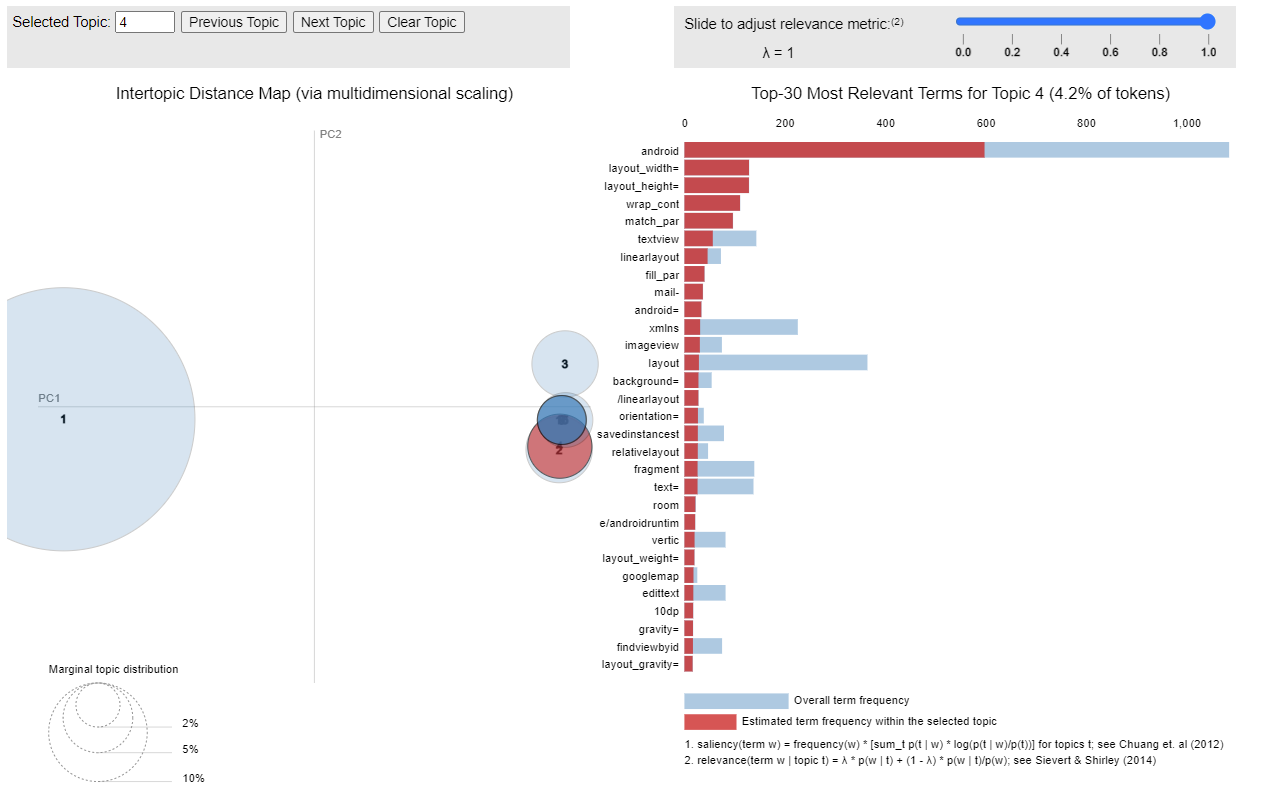